## Evaluating tests

This is a notebook discussing how one might evaluate a null-hypothesis significance test, to determine the best test for a given situations.

Clearly you need the right test, that measures what you want to measure. But beyond that there are two important issues.

First, many tests rely on certain assumptions about your data. While on the high level that's a yes-or-no question, in practice your data might not quite fit the assumptions, the distribution might not be quite normal, the  distributions might change over time. So it's also a question of how robust the test is to violations of the assumptions? In particular, what is the effect of the on the distribution of the p-values?

I suspect this might be best done by looking at the value (and maybe first derivative) of the PDF of p-values at $\alpha = 0$. That might be estimating using some version of the extreme value theorem.

Second, how powerful is the test? What's the power of the test, given an effect size and a false-positive rate? The is probably best measured through the area under what I call an alpha-beta curve, below.

In [1]:
import sys
sys.path.append('/Users/jackbennetto/git/graphing_tools/')

In [38]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvalues
import sys
from functools import partial
sys.path.append('/Users/bennetto/git')
from graphing_tools.graphing_tools import tools
%matplotlib inline

## Measuring goodness of p-value

As a first estimate of the goodness of fit, consider the distribution of p-values under certain conditions. Ideally, p-values are distributed uniformly between 0 and 1.

First, some code to plot p-values. Here's an actual uniform distribution, showing a KDE and the P-P plot (we use a P-P rather than Q-Q plot since we care about the location and scale of the distribution, not just the shape.)

In [11]:
data = stats.uniform(0, 1).rvs(100)

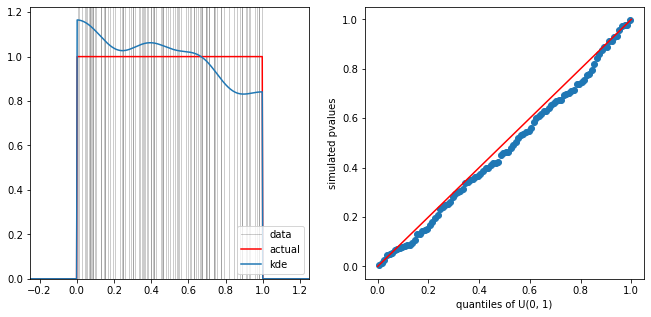

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
pvalues.plot_pvalues(ax[0],
                     data)
pvalues.plot_quantiles(ax[1],
                       data)

### alpha-beta curve

An alpha-beta curve (my term) is a way of measuring the overall power of a test, given a particular alternative hypothesis.  Rather than measuring the power at a single threshold or value of alpha, it plots alpha against beta.

This is analogous to an ROC curve. We can investigate it in the same way we'd look at the probabilistic interpretation of an ROC curve, with samples from one class ($H_0$) along the horizontal axis, and from the other ($H_A$) along the vertical, both ordered by increasing p-values.

Note that significant constraint of this approach is we need to consider an specific alternative hypothesis. Later we'll consider some parameterized $H_A$ and plot that parameter against the AUC.

To start, we'll consider a simple problem: determining if a set of points fit the normal distribution. We'll consider a few different options, using a few different alternative hypotheses.

It takes as input two random variables and a test statistic that operates on two samples. It is parameterized by the critical value. For each critical value, it plots the alpha (false-positive rate) for rejecting that two samples taken from the first are from the same distribution, against the beta (false negative rate) that samples taken form the each fail to reject the null.

In [80]:
def plot_alpha_beta_stats(ax,
                          stats_h0, stats_ha,
                          draw_lines=False,
                          color=None,
                          ms=None,
                          label=None):
    """
    Plot alpha-beta plot based from a two arrays of statistics,
    one in which the null hypothesis is true, one in which
    the alternative is."""
    # consider every possible threshold (criitcal value)
    thresholds = np.concatenate([stats_h0, stats_ha, [-np.Inf, np.Inf]])
    thresholds = np.unique(thresholds)
    
    alphas = np.zeros_like(thresholds)
    betas = np.zeros_like(thresholds)

    # calculate the alpha and beta if the threshold is set at each value
    # are we missing an endpoint?
    for i, crit in enumerate(thresholds):
        alphas[i] = ((crit > stats_h0).sum()/len(stats_h0))
        betas[i] = ((crit < stats_ha).sum()/len(stats_ha))
    
    # draw a grid to help us see what's happening
    if draw_lines:
        for alpha in np.unique(alphas):
            ax.axvline(alpha, lw=0.2)
        for beta in np.unique(betas):
            ax.axhline(beta, lw=0.2)

    ax.plot(alphas, betas, 'o-', color=color, ms=ms, label=label)
    ax.set_xlabel("alpha")
    ax.set_ylabel("beta")

    #ax.set_xlim(0, 1)
    #ax.set_ylim(0, 1)

    # return the AUC
    return ((stats_h0 > stats_ha[:, None]).mean() +
            (stats_h0 == stats_ha[:, None]).mean()/2)


In [81]:
def alpha_beta_comparison_plot(ax,
                    dist1, dist2,
                    sample_size,
                    statistic,
                    n_samples=10,
                    increasing=True,
                    draw_lines=False,
                    color=None,
                    ms=None,
                    label=None):
    """Generate an alpha-beta plot for tests comparing two
    independent samples.
    dist1 : the 1st distribution. The null hypothesis is that all
            data come from this distribution
    dist2 : the 2nd distribution. The alternative hypothesis is
            one sample comes from dist1 and one from dist2
    statistic : function to compare two samples"""
    # get samples from null and alternative distributions
    data1 = dist1.rvs((sample_size, n_samples))
    data2 = dist2.rvs((sample_size, n_samples))
    
    # calculate statistic between pairs within 
    stats_11 = np.zeros((n_samples, n_samples))
    stats_12 = np.zeros((n_samples, n_samples))
    
    for i in range(n_samples):
        for j in range(n_samples):
            stats_11[i, j] = statistic(data1[:, i], data1[:, j])[0]
            stats_12[i, j] = statistic(data1[:, i], data2[:, j])[0]
    stats_11 = stats_11[np.tril_indices(n_samples, -1)]
    stats_12 = stats_12.flatten()
    #print(stats_11.shape, stats_12.shape)
    return plot_alpha_beta_stats(ax, stats_11, stats_12,
                                 draw_lines,
                                 color=color,
                                 ms=ms,
                                 label=label)


Let's try an easy example: t-tests.

In [82]:
n_samples = 50
sample_size = 10

0.7975510204081633

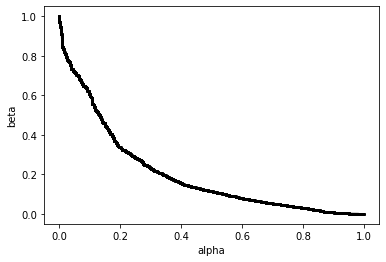

In [83]:
fig, ax = plt.subplots()
alpha_beta_comparison_plot(ax,
                stats.norm(0, 1),
                stats.norm(0.5, 1),
                sample_size=sample_size,
                statistic=stats.ttest_ind,
                n_samples=n_samples,
                draw_lines=False,
                color='k',
                ms=2)

Let's get fancier and compare different t-tests (Welch's vs students).

0.731285108040201 0.6801647386934674


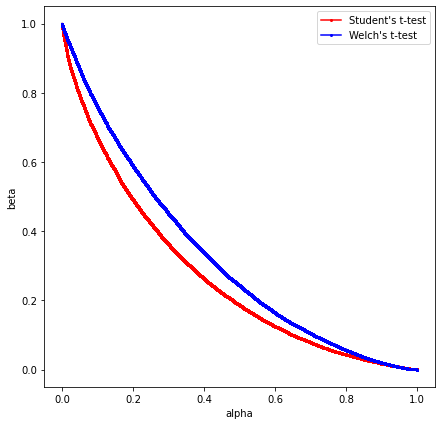

In [90]:
n_samples = 200
sample_size = 7

fig, ax = plt.subplots(figsize=(7, 7))
auc1=alpha_beta_comparison_plot(ax,
                stats.norm(0, 1),
                stats.norm(0.5, 1),
                sample_size=sample_size,
                statistic=partial(stats.ttest_ind, equal_var=True),
                n_samples=n_samples,
                draw_lines=False,
                color='red',
                ms=2,
                label="Student's t-test")

auc2=alpha_beta_comparison_plot(ax,
                stats.norm(0, 1),
                stats.norm(0.5, 1),
                sample_size=sample_size,
                statistic=partial(stats.ttest_ind, equal_var=False),
                n_samples=n_samples,
                draw_lines=False,
                color='blue',
                ms=2,
                label="Welch's t-test")
ax.legend()
print(auc1, auc2)

As expected, Welch's test has less power...but I'm not sure we have enough data.

0.832

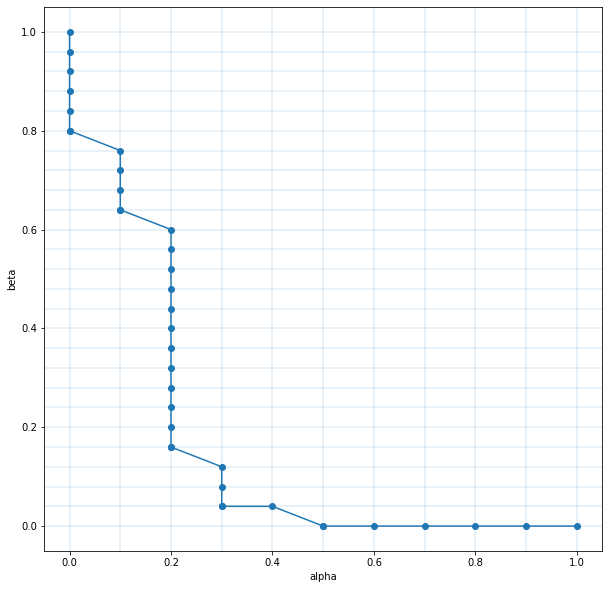

In [93]:
fig, ax = plt.subplots(figsize=(10, 10))

alpha_beta_comparison_plot(ax,
                stats.norm(0, 1),
                stats.norm(0.5, 1),
                sample_size=20,
                statistic=stats.ttest_ind,
                n_samples=5,
                draw_lines=True)

In [359]:
stats.kstest([1,2,3,4,5], [2,3,4,5,6])

KstestResult(statistic=0.2, pvalue=1.0)

Idea: test that includes whether gaps are bigger or smaller, and uses that in the test statistic. Try to make the statistic distribution free.

Think of ways the ordering and layout of element changes when we change the distribution, and look for things that change when you change the underlying distribution, and then you can measure anything that keeps that constant